In [7]:
import torchaudio
import torch
import pandas as pd
from speechbrain.pretrained import EncoderClassifier
from speechbrain.nnet.pooling import StatisticsPooling
from prepare import WaveformEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

In [8]:
from accents import *
# [ACCENTS_EN, ACCENTS_ES, ACCENTS_DE]

In [30]:
classes = ACCENTS_EN

In [10]:
# test_path = '/home/dan/slt/accent_data_es'
# source_path = '/home/dan/slt/embedding_model.ckpt'
# hparams_path = '/home/dan/slt/hyperparams.yaml'

In [24]:
test_path = '/home/dan/slt/accent_data'
source_path = '/home/dan/slt/model_en/'
hparams_path = '/home/dan/slt/model_en/hyperparams.yaml'

In [20]:
classifier = WaveformEncoder.from_hparams(source=source_path, hparams_file=hparams_path)

data/rir_folder/rirs_noises.zip exists. Skipping download


Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2Model: ['project_hid.weight', 'project_q.bias', 'project_hid.bias', 'quantizer.codevectors', 'quantizer.weight_proj.bias', 'quantizer.weight_proj.weight', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [21]:
def embeds(filepath):
    x, sr = torchaudio.load(filepath)
    out = classifier.mods.wav2vec2(x.cuda())
    pooling_layer = StatisticsPooling(return_std=False)
    return pooling_layer(out).squeeze().cpu().numpy()

In [25]:
test_items = pd.read_csv(f'{test_path}/test.csv')

In [26]:
embeddings = []

In [27]:
for index, row in test_items.iterrows():
    filepath = f"{test_path}/test/{row['utt_id']}.wav"
    embeddings.append(embeds(filepath))

## Classification stats

In [10]:
cm = confusion_matrix(y_true, y_pred, labels=classes)

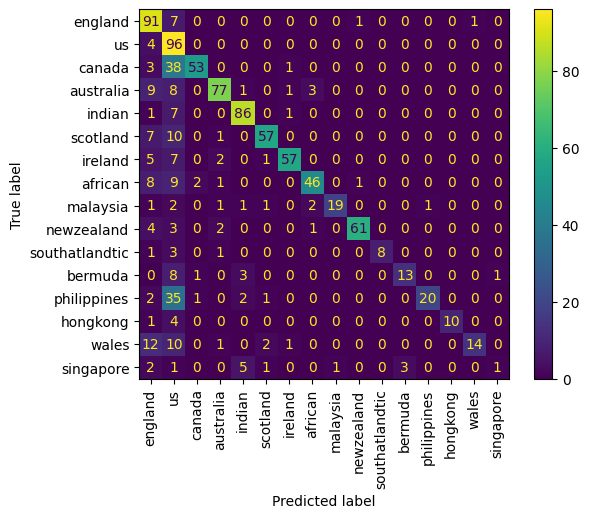

In [11]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
disp.plot()
disp.ax_.tick_params(axis='x', labelrotation = 90)

In [12]:
print(classification_report(y_true, y_pred))

                precision    recall  f1-score   support

       african       0.88      0.69      0.77        67
     australia       0.90      0.78      0.83        99
       bermuda       0.81      0.50      0.62        26
        canada       0.93      0.56      0.70        95
       england       0.60      0.91      0.73       100
      hongkong       1.00      0.67      0.80        15
        indian       0.88      0.91      0.89        95
       ireland       0.93      0.79      0.86        72
      malaysia       0.95      0.68      0.79        28
    newzealand       0.97      0.86      0.91        71
   philippines       0.95      0.33      0.49        61
      scotland       0.90      0.76      0.83        75
     singapore       0.50      0.07      0.12        14
southatlandtic       1.00      0.62      0.76        13
            us       0.39      0.96      0.55       100
         wales       0.93      0.35      0.51        40

      accuracy                           0.73 

## Exploring embeddings

In [35]:
n_components = 2
tsne = TSNE(n_components=n_components)
tsne_result = tsne.fit_transform(np.array(embeddings))

In [36]:
name_dict = {
    'us': 'US',
    'england': 'England',
    'australia': 'Australia',
    'indian': 'Indian',
    'canada': 'Canada',
    'bermuda': 'Bermuda',
    'scotland': 'Scotland',
    'african': 'African',
    'ireland': 'Ireland',
    'newzealand': 'New Zealand',
    'wales': 'Wales',
    'malaysia': 'Malaysia',
    'philippines': 'Philippines',
    'singapore': 'Singapore',
    'hongkong': 'Hong Kong',
    'southatlandtic': 'Southatlandtic',
}
reversed_name_dict = {v: k for k, v in name_dict.items()}

In [37]:
classes

['England',
 'US',
 'Canada',
 'Australia',
 'Indian',
 'Scotland',
 'Ireland',
 'African',
 'Malaysia',
 'New Zealand',
 'Southatlandtic',
 'Bermuda',
 'Philippines',
 'Hong Kong',
 'Wales',
 'Singapore']

african
australia
bermuda
canada
england
hongkong
indian
ireland
malaysia
newzealand
philippines
scotland
singapore
southatlandtic
us
wales


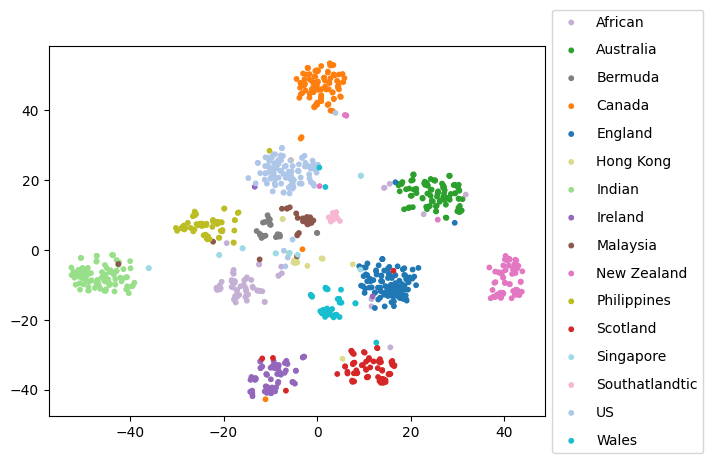

In [38]:
cmap = plt.get_cmap('tab20', len(classes))
fig, ax = plt.subplots()

groups = pd.DataFrame(tsne_result, columns=['x', 'y']).assign(accent=test_items['accent']).groupby('accent')
for name, points in groups:
    print(name)
    tfmd_classes = list(map(lambda x: reversed_name_dict[x], classes))
    c = cmap([classes.index(name_dict[name])] * len(points))
    ax.scatter(points.x, points.y, label=name_dict[name], s=10, color=c)

ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5), labelspacing=1);

In [39]:
fig.savefig('tsne_en.pdf', bbox_inches='tight')